In [11]:
# exact solution
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import odeint
from scipy.stats import norm

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'axes.labelsize': 12})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})
plt.rcParams.update({'legend.fontsize': 12})
plt.rcParams.update({'figure.figsize': (15,8)})

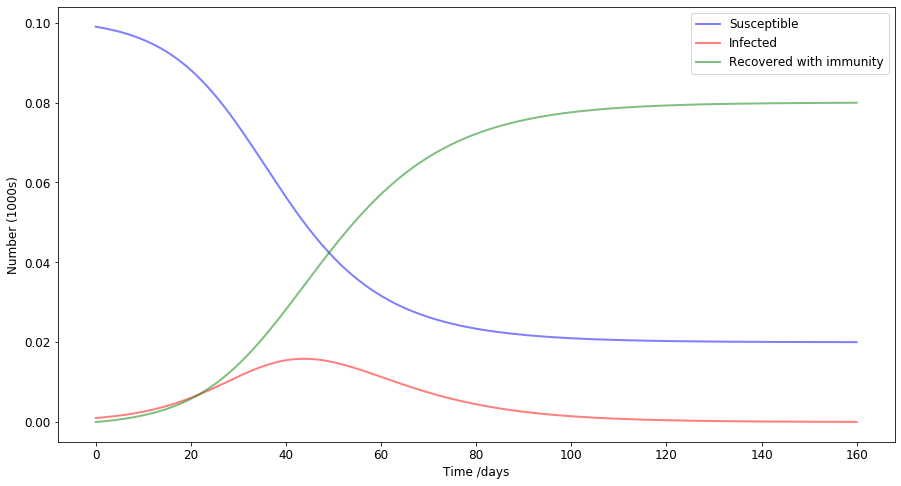

In [12]:
N = 100
I0, R0 = 1, 0
S0 = N - I0 - R0
beta, gamma = 0.2, 1./10 
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
plt.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
plt.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
plt.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
plt.xlabel('Time /days')
plt.ylabel('Number (1000s)')
plt.legend()
plt.show()

In [13]:
def calc_SIR(Nl, l, M, Npl=10**4, S0=100, I0=1, beta=0.2, gamma=1./10, T=1):
    num_rem=Nl 
    suml=np.zeros(7)    
    Nsteps=M**l
    dt=T/Nsteps
    sqrt_dt=np.sqrt(dt)
    
    while (num_rem>0): #<---Parallelise this while loop
        N_loop=min(Npl,num_rem) #Break up Nl into manageable chunks of size Npl, until last iteration
        num_rem-=N_loop #On final iteration N_loop=num_rem, so num_rem will be=0 and 
        
        #Initialise fine, coarse susceptible and infected individuals
        Sf=S0*np.ones(N_loop)
        Sc=S0*np.ones(N_loop)
        
        If=I0*np.ones(N_loop)
        Ic=I0*np.ones(N_loop)
        
        dWc=np.zeros(N_loop)
        for j in range(1,Nsteps+1): #Note that if Nsteps=1 (l=0), j=1 and so coarse path not developed
            dWf=np.random.randn(N_loop)*dt
            dWc=dWc+dWf #Keep adding to coarse BI every loop until j is integer multiple of M
            
            Sf-=beta*Sf*If*dt/N + np.sqrt(beta*Sf*If/N)*dWf # updating susceptible fine individuals 
            If+=(beta*Sf*If/N - gamma*If)*dt + np.sqrt(beta*Sf*If/N)*dWf # updating infected fine individuals 
            
            if j%M==0: #if j is integer multiple of M...
                Sc-=beta*Sc*Ic*dt/N + np.sqrt(beta*Sc*Ic/N)*dWc #...Develop coarse path
                Ic+=(beta*Sc*Ic/N - gamma*Ic)*dt + np.sqrt(beta*Sc*Ic/N)*dWc
                dWc=np.zeros(N_loop) #...Re-initialise coarse BI to 0
                
        sumPf=np.sum(Sf)
        sumPf2=np.sum(Sf**2)
        
        if l==0:
            suml+=np.array([sumPf,sumPf2,sumPf,sumPf2,0,0,0])
        else:
            dP_l=Sf-Sc #Payoff difference
            sumPc=np.sum(Sc)
            sumPc2=np.sum(Sc**2)
            fg=np.sum(Sc*Sf)
            suml+=np.array([np.sum(dP_l),np.sum(dP_l**2),sumPf,sumPf2,sumPc,sumPc2,fg])
            
    return suml

In [14]:
def mlmc(mlmc_fn,eps,N0=10**3,M=2,**kwargs):
    L = 2
    V=np.zeros(L+1) #Initialise variance vector of each levels' variance
    N=N0*np.ones(L+1) #Initialise num. samples vector of each levels' num. samples
    dN=N0*np.ones(L+1) #Initialise additional samples for this iteration vector for each level
    sums=np.zeros((7,L+1)) #Initialise sums array, each column is a level

    while (np.sum(dN)>0): #Loop until no additional samples asked for
        for l in range(L+1): 
            num=dN[l]
            if num>0: #If asked for additional samples...
                sums[:,l]+=mlmc_fn(int(num),l,M,**kwargs) #Call function which gives sums
                
        N+=dN #Increment samples taken counter for each level        
        V=np.maximum((sums[1,:]/N)-(sums[0,:]/N)**2,0) #Calculate variance based on updated samples
        Nl_new=N_opt(V,eps,L,M) #Estimate optimal number of samples at each level
        dN=np.maximum(0,Nl_new-N) #Number of additional samples
        if sum(dN > 0.01*N) == 0:
            if abs(sums[0,-1])/N[-1]>(M-1)*eps*np.sqrt(0.5):
                L+=1
                #Add extra entries for the new level and estimate sums with N0 samples 
                V=np.concatenate((V,np.zeros(1)), axis=0)
                N=np.concatenate((N,N0*np.ones(1)),axis=0)
                dN=np.concatenate((dN,N0*np.ones(1)),axis=0)
                sums=np.concatenate((sums,np.zeros((7,1))),axis=1)
                sums[:,L]+=mlmc_fn(N0,L,M,**kwargs)
                
    return sums,N

In [15]:
def N_opt(V,eps,L,M):
    sqrt_h=np.sqrt(M**(np.arange(0,L+1)))
    sqrt_V=np.sqrt(V)
    return np.ceil((2/eps**2)*np.sum(sqrt_V*sqrt_h)*sqrt_V/sqrt_h)

In [22]:
def mlmc_complexity2(mlmc_fn,eps,M=2,T=1,N0=10**3):
    cost_mlmc=[]
    cost_mc=[]
    fig,ax=plt.subplots(1,2,figsize=(15,8))
    fig.suptitle(f'SIR model, S(0)=100, I0=1')
    
    for e in eps:
        sums, N = mlmc(mlmc_fn,e,N0,M)
        L=len(N)-1
        means_p=sums[2,:]/N
        V_p=(sums[3,:]/N)-means_p**2

        cost_mlmc+=[(N[0]+(1+1/M)*np.sum(N[1:]*(M**np.arange(1,L+1))))*e**2]
        cost_mc+=[2*sum(V_p*M**np.arange(L+1))]
        ax[0].semilogy(range(L+1),N,label=f'{e}')
    
    ax[0].set_xlabel('$l$')
    ax[0].set_ylabel('$N_l$')
    ax[0].legend(title=r'$\epsilon$')
    xa=ax[0].xaxis
    xa.set_major_locator(ticker.MaxNLocator(integer=True))

    ax[1].loglog(eps,cost_mlmc,'k',label="SIR")
    ax[1].set_xlabel(r'$\epsilon$')
    ax[1].set_ylabel(r'$\epsilon^{2}$cost')
    ax[1].legend(['mlmc','mc'])

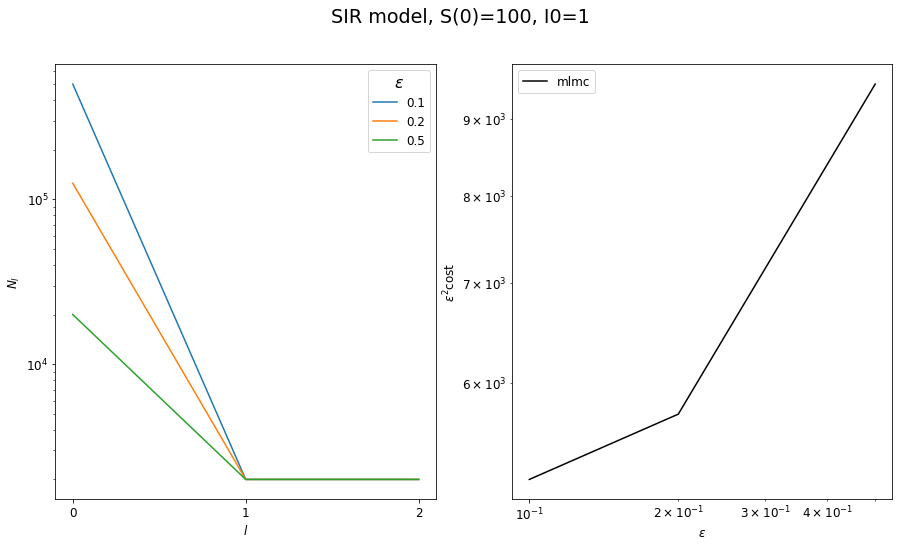

In [23]:
mlmc_complexity2(calc_SIR, [0.1,0.2,0.5])